In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand

from natsort import os_sorted
from matplotlib.patches import Patch
from scipy.stats import sem


In [2]:
big_meta = pd.read_csv('../../data/dtag_experiments/sum159_all_meta.tsv',sep='\t')

big_meta.index = [i.split('_Aligned')[0] for i in big_meta['Sample basename'].values]

In [3]:
def get_unproc_multigene(meta_df):
    proc_df = pd.DataFrame()
    for i,row in meta_df.iterrows():
        filepath = '../../data/dtag_experiments/' + \
            row['Target'] + \
            '/multigene_misproc/' + \
            row['Sample basename']
        proc_df = pd.concat([
            proc_df,
            pd.read_csv(glob.glob(filepath+'*tsv')[0],sep='\t',index_col='gene_id')['unprocessed']
        ],axis=1)
    proc_df.columns = meta_df.index
    return proc_df

def get_proc_multigene(meta_df):
    proc_df = pd.DataFrame()
    for i,row in meta_df.iterrows():
        filepath = '../../data/dtag_experiments/' + \
            row['Target'] + \
            '/multigene_misproc/' + \
            row['Sample basename']
        proc_df = pd.concat([
            proc_df,
            pd.read_csv(glob.glob(filepath+'*tsv')[0],sep='\t',index_col='gene_id')['processed']
        ],axis=1)
    proc_df.columns = meta_df.index
    return proc_df


In [4]:
proc_multi_all = get_proc_multigene(big_meta)
unproc_multi_all = get_unproc_multigene(big_meta)


/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [5]:
ok_genes = proc_multi_all[np.sum(proc_multi_all>200,axis=1) >= 0.9*len(proc_multi_all.columns)].index

In [6]:
misproc_values = np.sum(
    unproc_multi_all.loc[ok_genes]
)/(
    np.sum(unproc_multi_all.loc[ok_genes]) + \
    np.sum(proc_multi_all.loc[ok_genes])
)

In [7]:
code_order = [
    'U2AF2_True',
    'U2AF2_False',
    'DDX46_True',
    'DDX46_False',
    'SF3B1_True',
    'SF3B1_False',
    'PRPF8_True',
    'PRPF8_False',
    'DHX16_True',
    'DHX16_False',
    'AQR_True',
    'AQR_False',
    'DHX38_True',
    'DHX38_False',
    'DHX15_True',
    'DHX15_False',
]

color_dict = {
    'AQR':'tab:orange',
    'DDX46':'tab:brown',
    'DHX15':'tab:blue',
    'DHX16':'tab:cyan',
    'DHX38':'tab:pink',
    'PRPF8':'tab:green',
    'SF3B1':'tab:red',
    'U2AF2':'tab:purple'
}


In [8]:
def plot_swarm(x_order,yval_df,ax):
    for i in range(len(x_order)):
        xvals = np.array([rand.uniform(-0.2,0.2) for i in range(0,3)]) + i
        ax.scatter(
            xvals, 
            yval_df.loc[yval_df['code'] == x_order[i],'misproc'],
            c=color_dict[x_order[i].split('_')[0]]
        )
        
def plot_ranges(x_order,mean_df,error_df,ax):
    for i in range(len(x_order)):
        ax.plot(
            [i-0.3,i+0.3], 
            [mean_df.loc[x_order[i],0]]*2,
            c='k'
        )
        ax.plot(
            [i,i],
            [
                mean_df.loc[x_order[i],0]+error_df.loc[x_order[i],0],
                mean_df.loc[x_order[i],0]-error_df.loc[x_order[i],0]
            ],
            c='k'
        )
        ax.plot(
            [i-0.1,i+0.1], 
            [mean_df.loc[x_order[i],0]+error_df.loc[x_order[i],0]]*2,
            c='k'
        )
        ax.plot(
            [i-0.1,i+0.1], 
            [mean_df.loc[x_order[i],0]-error_df.loc[x_order[i],0]]*2,
            c='k'
        )
        
def plot_swarm_all(big_filt,ax):
    misproc_df = pd.DataFrame(
        [
            misproc_values.loc[big_filt.index],
            big_filt['Target'] + '_' + [str(i==0) for i in big_filt['Dosage value']]
        ]
    ).transpose()
    misproc_df.columns = ['misproc','code']

    tmp=[]

    for code in code_order:
        ctrl_code = code.split('_')[0] + '_True'
        misproc_norm = misproc_df.loc[
            misproc_df['code'] == code,'misproc'
        ] / np.mean(misproc_df.loc[misproc_df['code'] == ctrl_code,'misproc'])
        tmp.append(pd.DataFrame([
            misproc_norm,
            misproc_df.loc[misproc_df['code'] == code,'code']
        ]))

    misproc_norm_df = pd.concat(tmp,axis=1).transpose()

    bar_vals = []
    error_vals = []
    for i in code_order:
        inds = misproc_norm_df[misproc_norm_df['code'] == i].index
        bar_vals.append(np.mean(misproc_norm_df.loc[inds,'misproc']))
        error_vals.append(sem(misproc_norm_df.loc[inds,'misproc']))

    bar_vals = pd.DataFrame(bar_vals)
    error_vals = pd.DataFrame(error_vals)

    bar_vals.index = code_order
    error_vals.index = code_order
    
    plot_ranges(code_order,bar_vals,error_vals,ax)
    plot_swarm(code_order,misproc_norm_df,ax)

In [9]:
xticks = list(range(len(code_order)))
xtick_labs = [
    'U2AF2_Veh',
    'U2AF2_dTAG',
    'DDX46_Veh',
    'DDX46_dTAG',
    'SF3B1_Veh',
    'SF3B1_dTAG',
    'PRPF8_Veh',
    'PRPF8_dTAG',
    'DHX16_Veh',
    'DHX16_dTAG',
    'AQR_Veh',
    'AQR_dTAG',
    'DHX38_Veh',
    'DHX38_dTAG',
    'DHX15_Veh',
    'DHX15_dTAG',
]

In [10]:
big_filt_6 = big_meta.loc[
    ((big_meta['Dosage value']==0) |
    (big_meta['Dosage value']>100)) &
    (big_meta['Time value'] == 6)
]

big_filt_9 = big_meta.loc[
    ((big_meta['Dosage value']==0) |
    (big_meta['Dosage value']>100)) &
    ((big_meta['Time value']>6) & (big_meta['Time value']<12))
]


big_filt_12 = big_meta.loc[
    ((big_meta['Dosage value']==0) |
    (big_meta['Dosage value']>100)) &
    (big_meta['Time value'] == 12)
]




(0.7, 2.5)

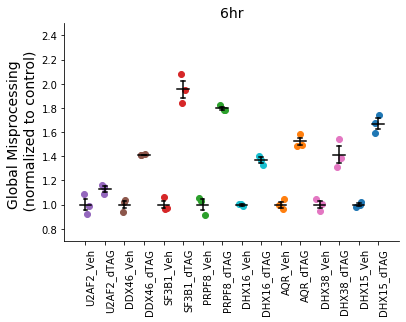

In [11]:
fig,ax = plt.subplots()

plot_swarm_all(big_filt_6,ax)

ax.set_ylabel('Global Misprocessing \n (normalized to control)', fontsize=14)
# ax.grid()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labs,
                   fontsize=10,
                   rotation=90,
                   ha='right', 
                   rotation_mode='anchor')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('6hr', fontsize=14)
ax.set_ylim([0.7,2.5])

(0.7, 2.5)

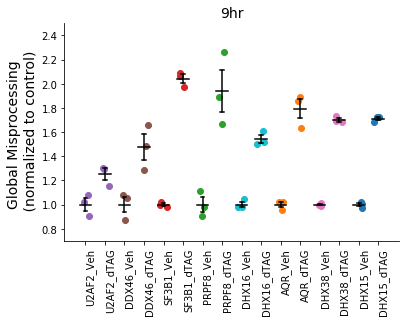

In [12]:
fig,ax = plt.subplots()

plot_swarm_all(big_filt_9,ax)

ax.set_ylabel('Global Misprocessing \n (normalized to control)', fontsize=14)
# ax.grid()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labs,
                   fontsize=10,
                   rotation=90,
                   ha='right', 
                   rotation_mode='anchor')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('9hr', fontsize=14)
ax.set_ylim([0.7,2.5])

(0.7, 2.5)

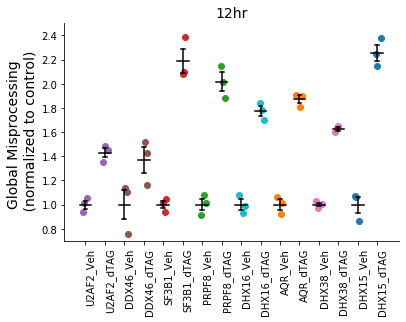

In [52]:
fig,ax = plt.subplots()

plot_swarm_all(big_filt_12,ax)

ax.set_ylabel('Global Misprocessing \n (normalized to control)', fontsize=14)
# ax.grid()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labs,
                   fontsize=10,
                   rotation=90,
                   ha='right', 
                   rotation_mode='anchor')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('12hr', fontsize=14)
ax.set_ylim([0.7,2.5])